# 0-Traimenent des videos

In [1]:
!git clone https://huggingface.co/datasets/friedrichor/MSR-VTT

Cloning into 'MSR-VTT'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 41 (delta 0), reused 0 (delta 0), pack-reused 38 (from 1)
Unpacking objects: 100% (41/41), 117.50 KiB | 4.35 MiB/s, done.


In [2]:
!unzip "/kaggle/working/MSR-VTT/MSRVTT_Videos.zip" > /dev/null

In [3]:
!ls "/kaggle/working/video" | wc -l

10000


In [4]:
# prompt: read the file json "/kaggle/working/MSR-VTT/msrvtt_test_1k.json"

import json

file_path = "/kaggle/working/MSR-VTT/msrvtt_train_7k.json"

try:
    with open(file_path, 'r') as f:
        data = json.load(f)
    print(len(data))
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
except json.JSONDecodeError:
    print(f"Error: Could not decode JSON from {file_path}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

7010


In [5]:
line = data[4999]
print(line)

{'video_id': 'video4999', 'video': 'video4999.mp4', 'caption': ['a man with cap standing near the horse and laughing', 'there is a tshirt man is talking with a horse', 'a guy is being interviewed standing at the back end of a horse when the horse starts farting', 'the man is interviewed and the horse starts to fart on his face', 'the men standing in the horse stable and he is enjoy their lovable horse', 'a man in a green hat standing by the rear end of a horse', 'a human and otter are talking to a reporter', 'a man in a green hat and white shirt is being interviewed in front of a horse when the horse decides to go to the bathroom', 'a man in a green cap is tanding near a horses butt as it farts', 'a man in a green hat talking about horses as a horse farts near his head', 'a man is standing by the ass of a horse as he is speaking the horse lets out a very loud fart', 'a man is being interview by a horse then the horse farts next to his face and everyone starts laughing', 'a man wearing 

In [6]:
# prompt: in the file /kaggle/working/MSR-VTT/msrvtt_train_7k.json read the first 5000 each line has the feild 'video' with indicate the video accociated in the folder 'video' and the feild 'caption' with is a list this video caption , so i want to create two file one has a id for video and its path , the other file contain the same id of video with its caption (each line has caption with id of video

video_info = []
caption_info = []
video_id_map = {}

# Limit to the first 5000 entries
limit = 7000
count = 0

for entry in data:
    if count >= limit:
        break

    video_id = entry['video_id']
    captions = entry['caption']

    # Add video info if not already added
    if video_id not in video_id_map:
        video_path = f"/kaggle/working/video/{video_id}.mp4" # Assuming .mp4 extension based on common video formats
        video_info.append({'video_id': video_id, 'video_path': video_path})
        video_id_map[video_id] = True

    # Add caption info
    for caption in captions:
      caption_info.append({'video_id': video_id, 'caption': caption})

    count += 1

In [7]:
# prompt: i want to convert the video_id into int id start from 1 to 5000 in the two lists

# Create a mapping from original video_id to integer id
original_to_int_id = {}
int_id_counter = 1

# Process video_info
new_video_info = []
for video_entry in video_info:
    original_video_id = video_entry['video_id']
    if original_video_id not in original_to_int_id:
        original_to_int_id[original_video_id] = int_id_counter
        int_id_counter += 1
    new_video_entry = video_entry.copy()
    new_video_entry['video_id'] = original_to_int_id[original_video_id]
    new_video_info.append(new_video_entry)

video_info = new_video_info

# Process caption_info
new_caption_info = []
for caption_entry in caption_info:
    original_video_id = caption_entry['video_id']
    new_caption_entry = caption_entry.copy()
    new_caption_entry['video_id'] = original_to_int_id[original_video_id]
    new_caption_info.append(new_caption_entry)

caption_info = new_caption_info

# Print the first few entries to verify
print("Processed video_info:")
for i in range(min(5, len(video_info))):
    print(video_info[i])

print("\nProcessed caption_info:")
for i in range(min(5, len(caption_info))):
    print(caption_info[i])

# Verify the number of unique integer ids
print(f"\nNumber of unique integer video IDs created: {len(original_to_int_id)}")


Processed video_info:
{'video_id': 1, 'video_path': '/kaggle/working/video/video0.mp4'}
{'video_id': 2, 'video_path': '/kaggle/working/video/video1.mp4'}
{'video_id': 3, 'video_path': '/kaggle/working/video/video2.mp4'}
{'video_id': 4, 'video_path': '/kaggle/working/video/video3.mp4'}
{'video_id': 5, 'video_path': '/kaggle/working/video/video4.mp4'}

Processed caption_info:
{'video_id': 1, 'caption': 'a car is shown'}
{'video_id': 1, 'caption': 'a group is dancing'}
{'video_id': 1, 'caption': 'a man drives a vehicle through the countryside'}
{'video_id': 1, 'caption': 'a man drives down the road in an audi'}
{'video_id': 1, 'caption': 'a man driving a car'}

Number of unique integer video IDs created: 7000


In [8]:
# Write video info to a file
with open('video_paths.txt', 'w') as f:
    for item in video_info:
        f.write(f"{item['video_id']} {item['video_path']}\n")

# Write caption info to a file
with open('captions.txt', 'w') as f:
    for item in caption_info:
        f.write(f"{item['video_id']} {item['caption']}\n")

print("Files 'video_paths.txt' and 'captions.txt' created successfully.")
print(f"Processed {count} entries.")

Files 'video_paths.txt' and 'captions.txt' created successfully.
Processed 7000 entries.


In [9]:
# clean up
!rm -r /kaggle/working/MSR-VTT

# 1-Extracting the frames from videos

In [10]:
# import necicary libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns


In [11]:
# Create frames directory in Colab's environment
os.makedirs('/kaggle/working/frames', exist_ok=True)

In [12]:
with open ("/kaggle/working/video_paths.txt", "r") as myfile:
    data = myfile.read().splitlines()

In [13]:
# Pre-filter videos with at least 80 frames
valid_videos = []
failed_data = 0
for line in data:
    parts = line.split()
    video_id = parts[0]
    url = parts[1]
    
    vidcap = cv2.VideoCapture(url)
    if not vidcap.isOpened():
        failed_data += 1
        continue
    
    # Check frame count
    total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames >= 40:
        valid_videos.append(line)
    
    vidcap.release()

print(f"Total videos: {len(data)}")
print(f"Videos with >=40 frames: {len(valid_videos)}")
print(f"Failed to open: {failed_data}")

Total videos: 7000
Videos with >=40 frames: 3723
Failed to open: 0


In [ ]:
images_list = []
data_size = len(data)
failed_data = 0
extr_40_success = 0
for line in data:
  parts = line.split()

  video_id = parts[0]
  url = parts[1]
  vidcap = cv2.VideoCapture(url)

  if not vidcap.isOpened():
      # print(f"Failed to open video: {url}")
      failed_data += 1
      continue

  count = 0
  while count < 40:  # Capture first 40 frames
      success, image = vidcap.read()
      if not success:
          break

      # Save frame with Colab path
      frame_path = f'/kaggle/working/frames/{video_id}-{count}.jpg'
      cv2.imwrite(frame_path, image)
      images_list.append(frame_path)
      count += 1

  if count == 40:
    extr_40_success += 1

  vidcap.release()

print(f"Failed data is {failed_data}/{data_size}")
print(f"Extracted 40 frames from {extr_40_success}/{data_size} videos")

Failed data is 0/7000
Extracted 40 frames from 3723/7000 videos


In [15]:
df = pd.DataFrame(images_list)
df.to_csv('frames.csv')
df.head()

,0
0,/kaggle/working/frames/1-0.jpg
1,/kaggle/working/frames/1-1.jpg
2,/kaggle/working/frames/1-2.jpg
3,/kaggle/working/frames/1-3.jpg
4,/kaggle/working/frames/1-4.jpg


# 2-Feature extraction

In [16]:
import numpy as np
# from keras.utils import np_utils
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Reshape, Dropout
# from keras.preprocessing.image import ImageDataGenerator
# from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
# --- 1. Set up the Distribution Strategy ---
# This tells TensorFlow to use all available GPUs and mirror the model across them.
import tensorflow as tf
strategy = tf.distribute.MirroredStrategy()
print(f"Number of devices: {strategy.num_replicas_in_sync}")

2025-06-21 16:58:06.990856: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750525087.456471      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750525087.558927      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Number of devices: 2


I0000 00:00:1750525106.138242      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750525106.138968      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [17]:
df = pd.read_csv('frames.csv')
df.rename(columns={'Unnamed: 0': 'index',
                   '0': 'image_path'},
          inplace=True)
df.head()

,index,image_path
0,0,/kaggle/working/frames/1-0.jpg
1,1,/kaggle/working/frames/1-1.jpg
2,2,/kaggle/working/frames/1-2.jpg
3,3,/kaggle/working/frames/1-3.jpg
4,4,/kaggle/working/frames/1-4.jpg


In [18]:
ids = []
for i in df['image_path']:
    ids.append(i.split('/')[-1].split('-')[0])

df['id'] = ids
df['id'] = df['id'].astype(int)
df.head()

,index,image_path,id
0,0,/kaggle/working/frames/1-0.jpg,1
1,1,/kaggle/working/frames/1-1.jpg,1
2,2,/kaggle/working/frames/1-2.jpg,1
3,3,/kaggle/working/frames/1-3.jpg,1
4,4,/kaggle/working/frames/1-4.jpg,1


In [19]:
# summary of data and statistic of column
df.describe()

,index,id
count,263787.000000,263787.000000
mean,131893.000000,3502.312078
std,76148.892067,2019.618716
min,0.000000,1.000000
25%,65946.500000,1758.000000
50%,131893.000000,3499.000000
75%,197839.500000,5249.000000
max,263786.000000,7000.000000


In [20]:
# Step 2: Model initialization
with strategy.scope():
    model = ResNet50(
        weights="imagenet",
        include_top=False,
        pooling='avg',
        input_shape=(224, 224, 3)
    )
    model_final = model  # Directly use the model

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [21]:
model_final.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [22]:
def load_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR → RGB
    img = preprocess_input(img)  # ResNet-specific normalization
    return img

In [23]:
# Create frames directory in Colab's environment
os.makedirs('/kaggle/working/' + 'movie_features', exist_ok=True)

In [ ]:
errors = []
min_frame = 100
for i in range(1,7000+1):
    try:
        n_path = '/kaggle/working/' + 'movie_features/' + str(i) + '.npy'
        image_list = list(df['image_path'][df['id'] == i])
        # print(i, f'is running , list_image :{len(image_list)}')
        if len(image_list) < min_frame:
            min_frame = len(image_list)
        if len(image_list) == 40:
            images = np.zeros((len(image_list), 224, 224, 3))
            for j in range(len(image_list)):
                img = load_image(image_list[j])
                images[j] = img

            images = np.array(images)
            feats = model_final.predict(images, batch_size=128)
            img_feats = np.array(feats)
            np.save(n_path,img_feats)
            print(i, 'is done')
    except:
        print('Error in: ', i)
        errors.append(i)

I0000 00:00:1750525117.390523   56149 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1750525117.390527   56150 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
2 is done
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
6 is done
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
7 is done
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
9 is done
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
10 is done
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
11 is done
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
16 is done
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
17 is done
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
19 is done
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
20 is done
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
21 is done
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
22 is done
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
26 is done
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
27 is done
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
28 is done
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
32 is done
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
34 is done
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
36 is done
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
40 is done
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
41 is done
1/1 ━━━

In [ ]:
print(min_frame)

In [ ]:
e_df = pd.DataFrame(errors)
e_df.to_csv('errors.csv')

In [ ]:
!ls "/kaggle/working/movie_features" | wc -l

In [ ]:
!rm -r /kaggle/working/frames

# 3-Captions Preprocessing

In [ ]:
import os, sys
import pandas as pd

In [ ]:
urls_path= '/kaggle/working/video_paths.txt'
caps_path= '/kaggle/working/captions.txt'

In [ ]:
f = open(caps_path, 'r')
captions = f.read().split("\n")
f.close()

In [ ]:
captions[1]

In [ ]:
ids = []
caps = []
for i in captions[:-1]:
  id = i.split(' ', 1)[0]
  cap = i.split(' ', 1)[1]
  new_cap =  "<start> " + cap + " <end>"
  ids.append(id)
  caps.append(new_cap)


In [ ]:
df = pd.DataFrame()
df['captions'] =  caps
df['id'] = ids

In [ ]:
df.head()

In [ ]:
feats_extract = []
# Loading all the numpy arrays at once and saving them in a dictionary
for filename in os.listdir('/kaggle/working/movie_features'):
    feats_extract.append(int(filename[:-4]))

In [ ]:
feats_extract[0]

In [ ]:
df['id'] = df['id'].astype(int)

In [ ]:
df = df[df.id.isin(feats_extract)]

In [ ]:
# Create frames directory in Colab's environment
os.makedirs('/kaggle/working/' + 'captions_lists', exist_ok=True)
df.to_csv('/kaggle/working/' + 'captions_lists/train_captions.csv', index=False)
df.head()

In [ ]:
train_list = df.values.tolist()

In [ ]:
import random
train_val_split = 0.85
random.shuffle(train_list)
training_list = train_list[:int(len(train_list)*train_val_split)]
validation_list = train_list[int(len(train_list)*train_val_split):]

In [ ]:
df = pd.DataFrame(training_list)
df.to_csv('/kaggle/working/' + 'captions_lists/training_list.csv', index=False)
df = pd.DataFrame(validation_list)
df.to_csv('/kaggle/working/' + 'captions_lists/validation_list.csv', index=False)


# 4-VTT Models

In [ ]:
import pandas as pd
import numpy as np

import os, sys
import pickle, functools, operator
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import joblib
from tensorflow.keras.utils import to_categorical
from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense, Bidirectional, Concatenate, Attention
from keras.callbacks import EarlyStopping, ModelCheckpoint
import json
import random
from tensorflow.keras.utils import plot_model

import tensorflow as tf
import datetime

time_steps_encoder=40
num_encoder_tokens = 2048  # Changed from 4096 to match ResNet50 features
latent_dim=512
time_steps_decoder=10
num_decoder_tokens=1500
batch_size=320

In [ ]:
training_df = pd.read_csv('/kaggle/working/' + 'captions_lists/training_list.csv')
val_df = pd.read_csv('/kaggle/working/' + 'captions_lists/validation_list.csv')

In [ ]:
training_list = training_df.values.tolist()
validation_list = val_df.values.tolist()
print(len(training_list), len(validation_list))

In [ ]:
vocab_list = []
for train in training_list:
    vocab_list.append(train[0])
print(vocab_list[0])

In [ ]:
tokenizer = Tokenizer(num_words=1500)
tokenizer.fit_on_texts(vocab_list)
# Verify
print(f"Actual vocabulary size: {len(tokenizer.word_index)}")  # Should be ≤1500

In [ ]:
x_data = {}
# Loading all the numpy arrays at once and saving them in a dictionary
for filename in os.listdir('/kaggle/working/' + 'movie_features'):
    f = np.load('/kaggle/working/' + 'movie_features/' + filename)
    x_data[int(filename[:-4])] = f

# print first 5
for key, value in list(x_data.items())[:5]:
    print(key, value.shape)

In [ ]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
import random

def load_dataset(batch_size, list_IDs, tokenizer, features_dict, time_steps_encoder, num_encoder_tokens, time_steps_decoder, num_decoder_tokens):
    """
    Generator function to create batches of data for the video captioning model.

    Args:
        batch_size (int): The size of each batch.
        list_IDs (list): A list of training/validation samples. Each sample is a list [caption, feature_id].
        tokenizer (keras.preprocessing.text.Tokenizer): The fitted tokenizer for captions.
        features_dict (dict): A dictionary mapping feature_id to the pre-extracted video features (numpy arrays).
        time_steps_encoder (int): The number of time steps for the encoder input (frames).
        num_encoder_tokens (int): The dimensionality of the features for each frame.
        time_steps_decoder (int): The fixed length of caption sequences for the decoder.
        num_decoder_tokens (int): The size of the vocabulary (number of decoder tokens).
    """
    while True:
        # Shuffle the data at the beginning of each epoch
        random.shuffle(list_IDs)

        # Iterate over the data in batches
        for i in range(0, len(list_IDs), batch_size):
            batch_list = list_IDs[i:i + batch_size]

            # Drop the last smaller batch to maintain batch dimension consistency
            if len(batch_list) < batch_size:
                continue

            # Initialize batch arrays for the encoder input and decoder input/target
            encoder_input_data = np.zeros((batch_size, time_steps_encoder, num_encoder_tokens), dtype='float32')
            decoder_input_data = np.zeros((batch_size, time_steps_decoder), dtype='int32')

            for j, (caption, feature_id) in enumerate(batch_list):
                # --- Encoder Input ---
                # Retrieve the pre-computed video features
                encoder_input_data[j] = features_dict[feature_id]

                # --- Decoder Data ---
                # Convert caption to a sequence of integers and apply padding
                seq = tokenizer.texts_to_sequences([caption])[0]
                padded_seq = pad_sequences([seq], maxlen=time_steps_decoder, padding='post', truncating='post')[0]
                decoder_input_data[j] = padded_seq

            # --- Prepare Decoder Target Data ---
            # The target data is the decoder input data shifted one time step to the left
            decoder_target_data_seq = np.copy(decoder_input_data)
            decoder_target_data_seq = np.roll(decoder_target_data_seq, -1, axis=1)
            decoder_target_data_seq[:, -1] = 0 # Set the final token of the target to padding

            # One-hot encode the decoder sequences
            decoder_input_one_hot = to_categorical(decoder_input_data, num_classes=num_decoder_tokens)
            decoder_target_one_hot = to_categorical(decoder_target_data_seq, num_classes=num_decoder_tokens)

            # NEW Corrected Line
            yield ((encoder_input_data, decoder_input_one_hot), decoder_target_one_hot)

In [ ]:
# --- 1. Define the Output Signature ---
# This blueprint tells TensorFlow the exact shape and type of each piece of data from the generator.
# We use 'None' for the batch size dimension to allow for variable batch sizes.
output_signature = (
    (
        tf.TensorSpec(shape=(None, time_steps_encoder, num_encoder_tokens), dtype=tf.float32),
        tf.TensorSpec(shape=(None, time_steps_decoder, num_decoder_tokens), dtype=tf.float32)
    ),
    tf.TensorSpec(shape=(None, time_steps_decoder, num_decoder_tokens), dtype=tf.float32)
)

# --- 2. Create the tf.data.Dataset objects ---
# We wrap the Python generator in tf.data.Dataset.from_generator, passing the signature.
# .repeat() is essential so the dataset doesn't exhaust after one epoch.
# .prefetch() is a performance optimization.
train_dataset = tf.data.Dataset.from_generator(
    lambda: load_dataset(batch_size, training_list, tokenizer, x_data, time_steps_encoder, num_encoder_tokens, time_steps_decoder, num_decoder_tokens),
    output_signature=output_signature
).repeat()

valid_dataset = tf.data.Dataset.from_generator(
    lambda: load_dataset(batch_size, validation_list, tokenizer, x_data, time_steps_encoder, num_encoder_tokens, time_steps_decoder, num_decoder_tokens),
    output_signature=output_signature
).repeat()


In [ ]:
time_steps_encoder=40
num_encoder_tokens = 2048  # Changed from 4096 to match ResNet50 features
latent_dim=512
time_steps_decoder=10
num_decoder_tokens=1500
batch_size=320

# Setting up the encoder
# Encoder with ResNet50 features
encoder_inputs = Input(shape=(time_steps_encoder, num_encoder_tokens), name="encoder_inputs")

# Consider using Bidirectional LSTM for better context
encoder = Bidirectional(
    LSTM(latent_dim, return_state=True, return_sequences=True, dropout=0.3, recurrent_dropout=0.2),
    name='bidirectional_encoder'
)

# For bidirectional LSTM, we get 4 states (forward_h, forward_c, backward_h, backward_c)
encoder_output, forward_h, forward_c, backward_h, backward_c = encoder(encoder_inputs)

# Concatenate forward and backward states
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(time_steps_decoder, num_decoder_tokens), name="decoder_inputs")

# Add attention mechanism for better performance
decoder_lstm = LSTM(
    latent_dim * 2,  # Double to match concatenated states
    return_sequences=True, 
    return_state=True, 
    name='decoder_lstm', 
    dropout=0.3,
    recurrent_dropout=0.2
)

# Attention layer
attention = Attention(name='attention_layer')
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, 
    initial_state=encoder_states
)

# Apply attention to encoder outputs
context_vector = attention([decoder_outputs, encoder_output])
decoder_combined_context = Concatenate(axis=-1)([decoder_outputs, context_vector])

# Dense layer with softmax for token prediction
decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='decoder_softmax')
decoder_outputs = decoder_dense(decoder_combined_context)

In [ ]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs, name='resnet_caption_model')
model.summary()

In [ ]:
# Early Stopping
earlystopping = EarlyStopping(monitor='val_loss', patience = 5, verbose=1, mode='min')

# Tensorboard callback
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# Run training
opt = tf.keras.optimizers.Adam(learning_rate= 0.01)
x = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1,patience=2,verbose=0,mode="auto")
model.compile(metrics=['accuracy'], optimizer=opt, loss='categorical_crossentropy')

In [55]:
# --- 3. Train the Model ---
# The model.fit call now uses the tf.data.Dataset objects.
history = model.fit(train_dataset,
                    validation_data=valid_dataset,
                    validation_steps=(len(validation_list) // batch_size),
                    epochs=15,
                    steps_per_epoch=(len(training_list) // batch_size),
                    callbacks=[x, earlystopping, tensorboard_callback])

197/197 ━━━━━━━━━━━━━━━━━━━━ 123s 622ms/step - accuracy: 0.5451 - loss: 2.1093 - val_accuracy: 0.5167 - val_loss: 2.4801 - learning_rate: 0.0100
Epoch 11/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 122s 621ms/step - accuracy: 0.5530 - loss: 2.0554 - val_accuracy: 0.5202 - val_loss: 2.4816 - learning_rate: 0.0100
Epoch 12/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 123s 622ms/step - accuracy: 0.5784 - loss: 1.8519 - val_accuracy: 0.5342 - val_loss: 2.3538 - learning_rate: 1.0000e-03
Epoch 13/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 122s 622ms/step - accuracy: 0.5913 - loss: 1.7631 - val_accuracy: 0.5340 - val_loss: 2.3641 - learning_rate: 1.0000e-03
Epoch 14/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 123s 623ms/step - accuracy: 0.5967 - loss: 1.7356 - val_accuracy: 0.5347 - val_loss: 2.3652 - learning_rate: 1.0000e-03
Epoch 15/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 123s 624ms/step - accuracy: 0.6015 - loss: 1.7081 - val_accuracy: 0.5356 - val_loss: 2.3597 - learning_rate: 1.0000e-04


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


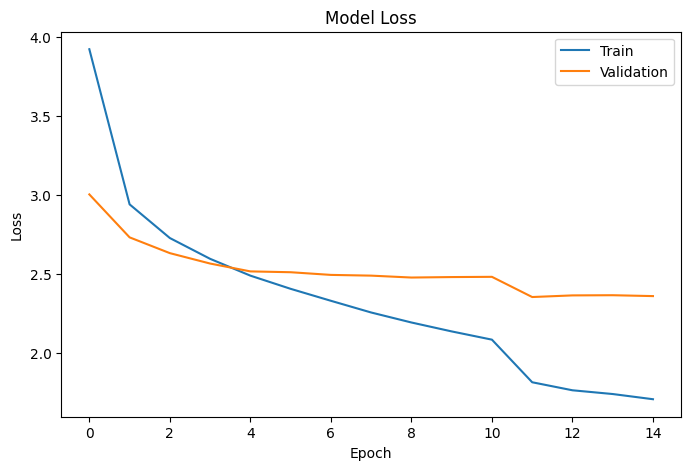

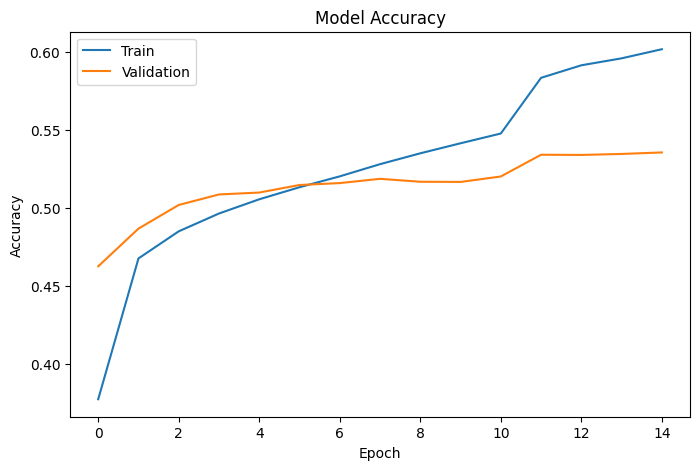

In [56]:
# --- 4. Plot the Results (this part remains the same) ---
import matplotlib.pyplot as plt

print(history.history.keys())

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('loss.png')
plt.show()

# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png')
plt.show()

In [57]:
# Save the full model
model.save('/kaggle/working/model/full_trained_captioning_model.h5')
print("Full trained model saved.")

# Encoder inference model - now outputs both states AND encoder outputs (for attention)
encoder_model = Model(encoder_inputs, [encoder_output] + encoder_states)
encoder_model.save('/kaggle/working/model/encoder_model.h5')
print("Encoder inference model saved.")

# Decoder inference model with attention
decoder_single_input_inf = Input(shape=(1, num_decoder_tokens), name="decoder_single_input_inf")
encoder_outputs_input = Input(shape=(time_steps_encoder, latent_dim * 2), name="encoder_outputs_input")  # New input for attention
decoder_state_input_h_inf = Input(shape=(latent_dim * 2,), name="decoder_state_input_h_inf")  # Double size
decoder_state_input_c_inf = Input(shape=(latent_dim * 2,), name="decoder_state_input_c_inf")  # Double size
decoder_states_inputs_inf = [decoder_state_input_h_inf, decoder_state_input_c_inf]

# Re-use trained layers
decoder_outputs_inf, state_h_inf_out, state_c_inf_out = decoder_lstm(
    decoder_single_input_inf, 
    initial_state=decoder_states_inputs_inf
)

# Attention mechanism for inference
context_vector_inf = attention([decoder_outputs_inf, encoder_outputs_input])
decoder_combined_context_inf = Concatenate(axis=-1)([decoder_outputs_inf, context_vector_inf])
decoder_outputs_inf = decoder_dense(decoder_combined_context_inf)

decoder_model_inference = Model(
    [decoder_single_input_inf, encoder_outputs_input] + decoder_states_inputs_inf,
    [decoder_outputs_inf, state_h_inf_out, state_c_inf_out],
    name="decoder_inference_model"
)

decoder_model_inference.save('/kaggle/working/model/decoder_inference_model.h5')
decoder_model_inference.summary()
print("Decoder inference model saved.")

# Save tokenizer
with open('/kaggle/working/model/tokenizer'+ str(num_decoder_tokens),'wb') as file:
    joblib.dump(tokenizer, file)
print("Tokenizer saved.")

Full trained model saved.
Encoder inference model saved.


Model: "decoder_inference_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ decoder_single_input_inf  │ (None, 1, 1500)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_state_input_h_inf │ (None, 1024)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_state_input_c_inf │ (None, 1024)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_lstm (LSTM)       │ [(None, 1, 1024),      │     10,342,400 │ decoder_single_input_… │
│                           │ (None, 1024), (None,   │                │ decoder_state_input_h… │
│                           │ 1024)]                 │                │ decoder_state_input_c… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_outputs_input     │ (None, 40, 1024)       │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ (None, 1, 1024)        │              0 │ decoder_lstm[1][0],    │
│ (Attention)               │                        │                │ encoder_outputs_input… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 1, 2048)        │              0 │ decoder_lstm[1][0],    │
│ (Concatenate)             │                        │                │ attention_layer[1][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_softmax (Dense)   │ (None, 1, 1500)        │      3,073,500 │ concatenate_3[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 13,415,900 (51.18 MB)

 Trainable params: 13,415,900 (51.18 MB)

 Non-trainable params: 0 (0.00 B)

Decoder inference model saved.
Tokenizer saved.


# 5-Test Model

In [58]:
import cv2
import numpy as np
from keras.models import Model, load_model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

# 1. Recreate the original feature extractor model
# Replace VGG16 with ResNet50 feature extractor
base_model = ResNet50(weights="imagenet", include_top=False, pooling='avg')
feature_extractor_model = Model(inputs=base_model.input, outputs=base_model.output)

def extract_features_from_video(video_path, frame_interval=1):
    """
    Extracts 4096-dimensional features from a video using the correct VGG16 fc2 layer.
    """
    cap = cv2.VideoCapture(video_path)
    features = []
    
    # Process frames until the video ends or we have 80 frames
    while cap.isOpened() and len(features) < 40:
        ret, frame = cap.read()
        if not ret:
            break

        if int(cap.get(cv2.CAP_PROP_POS_FRAMES)) % frame_interval == 0:
            # Preprocess frame for VGG16
            frame = cv2.resize(frame, (224, 224))
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # ResNet requires RGB
            frame = resnet_preprocess(frame)  # ResNet-specific preprocessing
            features.append(frame)

    cap.release()

    if not features:
        # Handle case with no frames
        return np.zeros((1, 40, 2048))  # ResNet features are 2048-dimensional

    # Convert list of frames to a numpy array
    video_frames = np.array(features)
    
    # Extract features using the correct model
    extracted_features = feature_extractor_model.predict(video_frames, batch_size=32)

    return extracted_features

In [59]:
import numpy as np

def prepare_encoder_input(features):
    """
    Pads or truncates the extracted features to exactly 80 timesteps.
    The feature dimension is now correctly 4096.
    """
    num_features = features.shape[0]
    feature_dim = 2048  # ResNet50 feature dimension

    # Pad with zeros if fewer than 80 frames were extracted
    if num_features < 40:
        padding = np.zeros((40 - num_features, feature_dim))
        features = np.vstack([features, padding])
    # Truncate if more than 80 frames were extracted (though our loop prevents this)
    elif num_features > 40:
        features = features[:40]
        
    # Add the batch dimension for the encoder model
    return np.expand_dims(features, axis=0)

In [60]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import joblib
import numpy as np
# Load models with custom objects for attention
from keras.layers import Attention
custom_objects = {'Attention': Attention}

# Load models and tokenizer
loaded_encoder_model = load_model('/kaggle/working/model/encoder_model.h5', custom_objects=custom_objects)
# Load decoder model architecture first
loaded_decoder_model = load_model('/kaggle/working/model/decoder_inference_model.h5', custom_objects=custom_objects)
with open('/kaggle/working/model/tokenizer1500', 'rb') as file:
    loaded_tokenizer = joblib.load(file)

print("Start token index:", loaded_tokenizer.word_index.get('start'))
print("'man' in vocabulary?", 'man' in loaded_tokenizer.word_index)
print("Vocabulary size:", len(loaded_tokenizer.word_index))

start_idx = loaded_tokenizer.word_index['start']
print(f"Start token index: {start_idx}")  # Should be <1500

# Should output (1, 1, 1500)
target_seq = np.zeros((1, 1, num_decoder_tokens))
target_seq[0, 0, start_idx] = 1
print(target_seq.shape)

time_steps_encoder=40
num_encoder_tokens = 2048  # Changed from 4096 to match ResNet50 features
latent_dim=512
time_steps_decoder=10
num_decoder_tokens=1500
batch_size=320

@tf.function
def decoder_predict_step(inputs):
    return loaded_decoder_model(inputs)

def generate_caption(video_features):
    # Encoder now returns [encoder_output, state_h, state_c]
    encoder_outputs = loaded_encoder_model.predict(video_features)
    encoder_output = encoder_outputs[0]  # Full sequence output
    states = encoder_outputs[1:]  # [state_h, state_c]
    
    target_seq = np.zeros((1, 1, num_decoder_tokens), dtype=np.float32)
    start_token_index = loaded_tokenizer.word_index.get('start')
    target_seq[0, 0, start_token_index] = 1
    
    caption = []
    h, c = states
    
    for _ in range(time_steps_decoder):
        # For ResNet+attention decoder: [target_seq, encoder_output, h, c]
        inputs = [target_seq, encoder_output, h, c]
        outputs = decoder_predict_step(tf.nest.map_structure(tf.convert_to_tensor, inputs))
        
        output_tokens = outputs[0]
        h = outputs[1]
        c = outputs[2]
        
        sampled_token_index = tf.argmax(output_tokens[0, -1, :]).numpy()
        sampled_word = loaded_tokenizer.index_word.get(sampled_token_index, '<unknown>')
        caption.append(sampled_word)
        
        if sampled_word == 'end':
            break
            
        # Update target sequence
        target_seq = np.zeros((1, 1, num_decoder_tokens), dtype=np.float32)
        target_seq[0, 0, sampled_token_index] = 1
        
    return ' '.join(caption)

# Step 1: Extract features from video
video_features = extract_features_from_video('/kaggle/working/video/video1005.mp4')
print(f'shape of video_features: {video_features.shape}')
# Step 2: Prepare encoder input
encoder_input = prepare_encoder_input(video_features)
print(f'shape of encoder_input: {encoder_input.shape}')
# Step 3: Generate caption
caption = generate_caption(encoder_input)
print("Generated Caption:", caption)

Start token index: 3
'man' in vocabulary? True
Vocabulary size: 17092
Start token index: 3
(1, 1, 1500)


I0000 00:00:1750529257.701216   56148 service.cc:148] XLA service 0x7d5740b5d310 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750529257.707050   56148 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750529257.707074   56148 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


I0000 00:00:1750529262.374797   56148 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


shape of video_features: (32, 2048)
shape of encoder_input: (1, 40, 2048)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Generated Caption: a man is talking about a movie end


In [61]:
# Function to process a single video
def process_video(video_path):
    try:
        print(f"\nProcessing {video_path.split('/')[-1]}")
        # Step 1: Extract features
        video_features = extract_features_from_video(video_path)
        print(f"  Feature shape: {video_features.shape}")
        
        # Step 2: Prepare encoder input
        encoder_input = prepare_encoder_input(video_features)
        print(f"  Encoder input shape: {encoder_input.shape}")
        
        # Step 3: Generate caption
        caption = generate_caption(encoder_input)
        return caption
    except Exception as e:
        print(f"Error processing {video_path}: {str(e)}")
        return None

test_videos = [
    '/kaggle/working/video/video1005.mp4',
    '/kaggle/working/video/video1006.mp4',
    '/kaggle/working/video/video1007.mp4',
    '/kaggle/working/video/video1008.mp4',
    '/kaggle/working/video/video1009.mp4',
    '/kaggle/working/video/video1010.mp4',
    '/kaggle/working/video/video1011.mp4',
    '/kaggle/working/video/video1012.mp4',
    '/kaggle/working/video/video1013.mp4',
    '/kaggle/working/video/video1014.mp4',
]

# Process all test videos
results = []
for video_path in test_videos:
    caption = process_video(video_path)
    if caption:
        results.append((video_path, caption))
        print(f"Generated Caption: {caption}\n{'='*50}")

# Print final results
print("\n\n==== FINAL RESULTS ====")
for path, caption in results:
    print(f"Video: {path.split('/')[-1]}")
    print(f"Caption: {caption}")
    print('-'*50)


Processing video1005.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
  Feature shape: (32, 2048)
  Encoder input shape: (1, 40, 2048)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Generated Caption: a man is talking about a movie end

Processing video1006.mp4
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 5s/step  
  Feature shape: (38, 2048)
  Encoder input shape: (1, 40, 2048)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Generated Caption: a video game is being played end

Processing video1007.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
  Feature shape: (32, 2048)
  Encoder input shape: (1, 40, 2048)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Generated Caption: a man is playing a video game end

Processing video1008.mp4
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step  
  Feature shape: (40, 2048)
  Encoder input shape: (1, 40, 2048)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Generated Caption: a man is cooking end

Processing video1009.mp4
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
  Feature shape: (40, 2048)
  Encoder input shape: (1, 40, 2048)
1/

In [62]:
# Example reference captions (replace with your actual data)
reference_captions = {
    'video1005.mp4': [
            "a man is hailing a cab",
            "a man is pretending to hail a taxi on a city street",
            "a man is walking down a street",
        ],
    'video1006.mp4': [
            "a game is played",
            "a person is playing a video game",
            "a person playing a video game and commentating",
        ],
    'video1007.mp4': [
            "a man is wrestling",
            "a man picks up another man and slams him on the ground in a wrestling ring",
            "a short clip showcasing a wrestling match taking place",
        ],
    'video1008.mp4': [
            "a man has a cup of onions",
            "a man is filling a cup with something to eat",
            "a man is fixing a cup of food",
        ],
    'video1009.mp4': [
            "a crowd is standing in a line a woman is talking to a crowd",
            "a news cast showcasing hilary clinton giving a talk",
            "a news channel is showing hillary clinton speaking",
        ],
    'video1010.mp4': [
            "in studio aa virtual studio a woman shows two different locations that have been shot there",
            "the woman in blue and black dress talk about some interesting topic",
            "there is a woman in black is anchoring a show",
        ],
    'video1011.mp4': [
            "a car driving down a road goes from black and white video to colored video",
            "a car driving down the road",
            "a clip from an old show",
        ],
    'video1012.mp4': [
            "a blonde woman in a white lab coat is followed by red and black clips attached to silver pins",
            "a man in a gray hoodie looks at machinery and red and black hooks are attached to silver pins",
            "a boy along with few others are looking at a device",
        ],
    'video1013.mp4': [
            "a man is singing in multiple shots",
            "a man playing guitar and singing",
            "a man plays guitar and sings",
        ],
    'video1014.mp4': [
            "a game of golf",
            "a golf sport video game",
            "a man is playing a golfing video game",
        ],
}

In [63]:
!pip install nltk
!pip install rouge-score
import nltk
nltk.download('punkt')

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=442430f70877052132bef439fb1ef8975e3bc857f6fab0b005d0a4290635f1ad
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [64]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
import numpy as np

def evaluate_captions(generated_captions, reference_captions):
    """Calculate BLEU, ROUGE-L, and METEOR scores"""
    # Prepare data structures
    refs = []
    hyps = []
    filenames = []
    
    # Organize data for metrics
    for filename, generated in generated_captions.items():
        if filename in reference_captions:
            refs.append(reference_captions[filename])
            hyps.append(generated)
            filenames.append(filename)
    
    # Tokenize for metrics
    tokenized_refs = [[ref.split() for ref in ref_group] for ref_group in refs]
    tokenized_hyps = [hyp.split() for hyp in hyps]
    
    # Calculate BLEU scores
    smoothing = SmoothingFunction().method1
    bleu1 = corpus_bleu(tokenized_refs, tokenized_hyps, weights=(1, 0, 0, 0), smoothing_function=smoothing)
    bleu4 = corpus_bleu(tokenized_refs, tokenized_hyps, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing)
    
    # Calculate ROUGE-L
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    rouge_scores = []
    for i, filename in enumerate(filenames):
        hyp = generated_captions[filename]
        ref_group = reference_captions[filename]
        # Take max ROUGE across references
        rouge_scores.append(max([scorer.score(ref, hyp)['rougeL'].fmeasure for ref in ref_group]))
    avg_rouge = np.mean(rouge_scores)
    
    # Calculate METEOR (alternative to CIDEr)
    meteor_scores = []
    for i, filename in enumerate(filenames):
        hyp = tokenized_hyps[i]
        ref_group = tokenized_refs[i]
        # METEOR requires tokenized inputs
        meteor_scores.append(
            max([meteor_score([ref], hyp) for ref in ref_group])
        )
    avg_meteor = np.mean(meteor_scores)
    
    return {
        'BLEU-1': bleu1,
        'BLEU-4': bleu4,
        'ROUGE-L': avg_rouge,
        'METEOR': avg_meteor
    }

generated_captions = {}
for video_path in test_videos:
    try:
        # Extract video filename
        filename = video_path.split('/')[-1]
        
        # Process video
        video_features = extract_features_from_video(video_path)
        encoder_input = prepare_encoder_input(video_features)
        caption = generate_caption(encoder_input)
        
        # Store result
        generated_captions[filename] = caption
        print(f"Video: {filename}\nGenerated: {caption}\n")
        
    except Exception as e:
        print(f"Error processing {video_path}: {str(e)}")

# Evaluate performance
if generated_captions:
    metrics = evaluate_captions(generated_captions, reference_captions)
    print("\n=== Evaluation Metrics ===")
    print(f"BLEU-1: {metrics['BLEU-1']:.4f}")
    print(f"BLEU-4: {metrics['BLEU-4']:.4f}")
    print(f"ROUGE-L: {metrics['ROUGE-L']:.4f}")
    print(f"METEOR: {metrics['METEOR']:.4f}")
else:
    print("No captions generated for evaluation")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Video: video1005.mp4
Generated: a man is talking about a movie end

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Video: video1006.mp4
Generated: a video game is being played end

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Video: video1007.mp4
Generated: a man is playing a video game end

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Video: video1008.mp4
Generated: a man is cooking end

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Video: video1009.mp4
Generated: a man is talking about a woman who left <unknown>

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Video: video1010.mp4
Generated: a man is talking about a end

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Video: video1011.mp4
Generated: a man is talking about a car end